In [18]:
import Pkg
Pkg.activate("../../../../FinancialPlanner/_wip/TCVAR")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\TCVAR`


In [19]:
using Revise
using LinearAlgebra
using Statistics
using Plots


includet("../src/TCVAR.jl")

using .TCVAR

In [20]:
trend_mapping = [1 0
                 1 1]

true_var_coeff = [.3 .1;  .4 .6]
true_trend_covariance =  diagm([2/10, 1/10] .^2) 

p = -0.7 * .03 * 0.01

true_cycle_covariance = [(2.)^2 p
                         p (1.)^2]

     
true_initial_trend_mean = [2., 1.]
true_initial_trend_covariance = Matrix(I, 2,2)
true_initial_cycle_mean = [.0, .0]
true_initial_cycle_covariance = [(2.)^2 0
                                 0 (1.)^2]
                                   
    
true_model = tc_var(trend_mapping,
                    true_var_coeff, 
                    true_trend_covariance, 
                    true_cycle_covariance, 
                    true_initial_trend_mean, 
                    true_initial_cycle_mean, 
                    true_initial_trend_covariance, 
                    true_initial_cycle_covariance)


initial_state = [.02, .008]
true_states, observations =  sample(true_model,  [2., 1., .0, .0], 100)

n_presample = 20

presample_data, data = observations[1:n_presample,:], observations[n_presample+1:end,:]

true_states = true_states[n_presample+1:end,:]
  

80×4 Matrix{Float64}:
 3.20371  1.26817   -0.353275   1.17331
 3.21092  1.18393   -1.07141   -0.201827
 3.5173   1.10988   -1.34319   -0.657717
 3.46396  1.11893    0.415765  -1.36553
 3.2335   1.31728   -1.18049   -2.08212
 3.23743  1.409      3.75648   -1.98643
 3.15582  1.32747    0.880145   2.89952
 3.38645  1.3517    -0.318401   1.25248
 3.35791  1.13237   -0.788897   2.45586
 3.46472  1.13516    2.64014    1.39292
 ⋮                             
 2.9073   0.664171  -1.71094   -1.76201
 3.23469  0.710689  -3.4787    -1.41655
 3.22469  0.65245    0.641069  -1.42251
 3.11053  0.586767   0.418677  -0.882034
 3.16383  0.604799   2.40872   -1.30934
 3.08418  0.495742  -0.919844  -0.0608761
 3.46783  0.4248    -1.82207   -0.444807
 3.26525  0.360235   2.51722   -2.26542
 3.39417  0.284478   0.193691  -2.04333

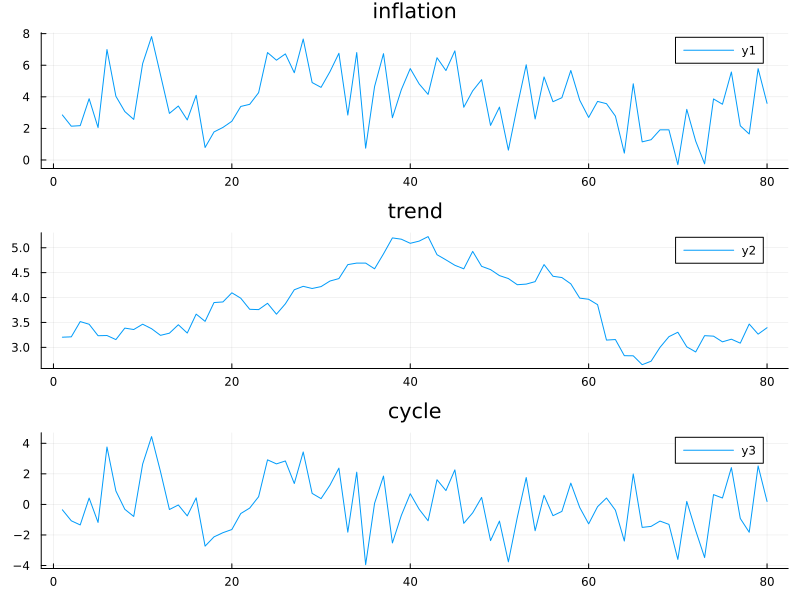

In [21]:
plot_variable_states(data[:, 1], true_states[:, [1,3]], ["inflation" "trend" "cycle"])

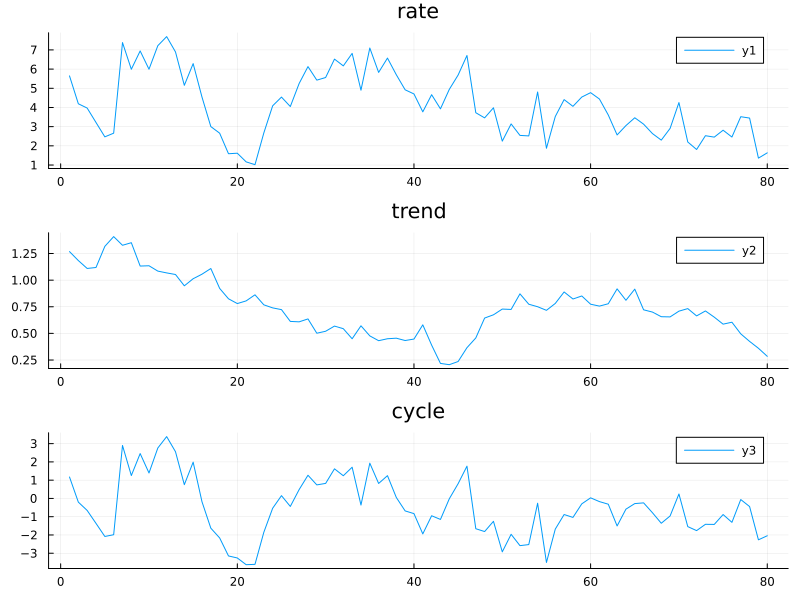

In [22]:
plot_variable_states(data[:, 2], true_states[:, [2,4]], ["rate" "trend" "cycle"])

In [23]:
presample_mean = [mean(presample_data[:,1], dims=1)[1], mean(presample_data[:,2] - presample_data[:,1], dims=1)[1]]
display(presample_mean)

presample_variance = var(presample_data, dims=1)[1,:]
display(presample_variance)
display(presample_variance.^.5)


2-element Vector{Float64}:
 2.204946966698812
 2.1267485835020894

2-element Vector{Float64}:
 4.824735553682679
 1.9561516405297241

2-element Vector{Float64}:
 2.1965280680388948
 1.3986249105924449

In [24]:
n = 2 #number of observatin variables

priors = (
        initial_trend_mean = presample_mean,
        initial_cycle_mean = zeros(2),
        initial_trend_covariance = diagm([1., 1.]),
        trend_covariance_df = 100,
        trend_covariance_mean = diagm([2. /10, 1. /20].^2),
        cycle_coeff_mean = zeros(2, 2),
        cycle_coeff_shrinkage_param = .2,
        cycle_covariance_mean = diagm(presample_variance), #diagm(presample_variance), 
        cycle_covariance_df = n+2
        )


(initial_trend_mean = [2.204946966698812, 2.1267485835020894], initial_cycle_mean = [0.0, 0.0], initial_trend_covariance = [1.0 0.0; 0.0 1.0], trend_covariance_df = 100, trend_covariance_mean = [0.04000000000000001 0.0; 0.0 0.0025000000000000005], cycle_coeff_mean = [0.0 0.0; 0.0 0.0], cycle_coeff_shrinkage_param = 0.2, cycle_covariance_mean = [4.824735553682679 0.0; 0.0 1.9561516405297241], cycle_covariance_df = 4)

In [25]:
trend_states_samples, cycle_states_samples, trend_covariance_samples, betas_samples, sigmas_samples = gibs_sampler(data, trend_mapping, priors; burnin = 5_000, n_samples = 5_000, thin=5)

trend_states_mean, trend_states_lower, trend_states_upper = compute_posterior_statistics(trend_states_samples, credible_level=0.95)  
cycle_states_mean, cycle_states_lower, cycle_states_upper = compute_posterior_statistics(cycle_states_samples, credible_level=0.95) 

([-0.6156923600365614 1.466436264084593; -1.3544089826900128 -0.005734557494205271; … ; 3.018063569867002 -1.7251541571631979; 0.8478503371008782 -1.4256751506087029], [-1.6890152764736568 0.2281007345206658; -2.466185677250812 -1.252896669330678; … ; 1.737297175264815 -3.1073284784654875; -0.39742451642973337 -2.8247863563302578], [0.3892897800281283 2.720508903727184; -0.3616068739405167 1.161208784348407; … ; 4.2179663143929185 -0.4055585218643062; 2.0957566158430754 -0.14194256074446404])

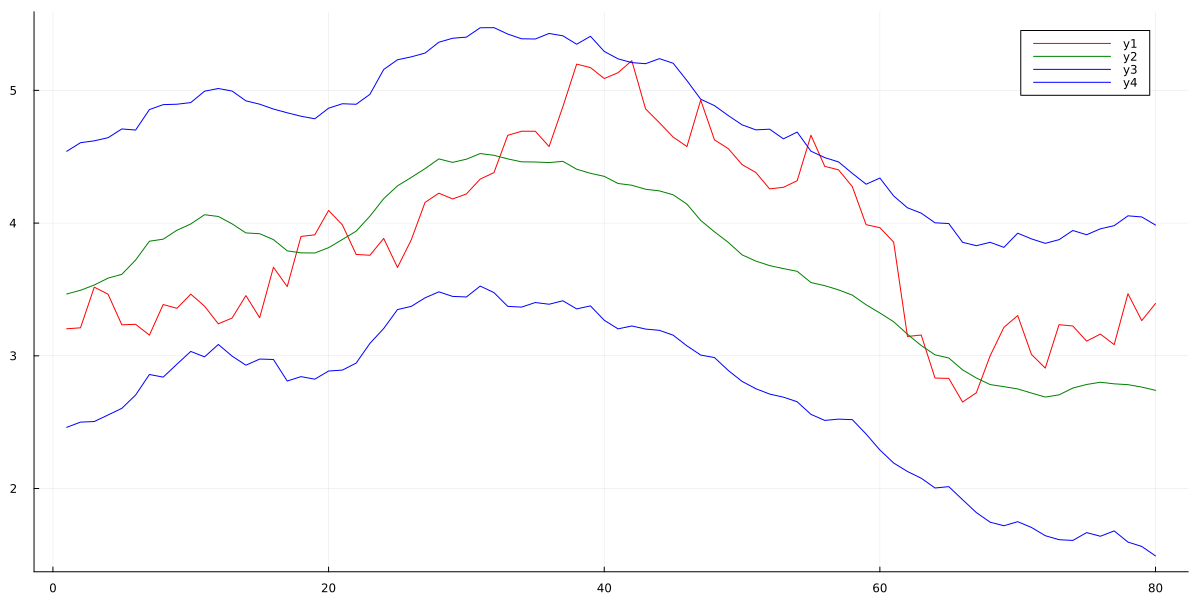

In [26]:
st = 1
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

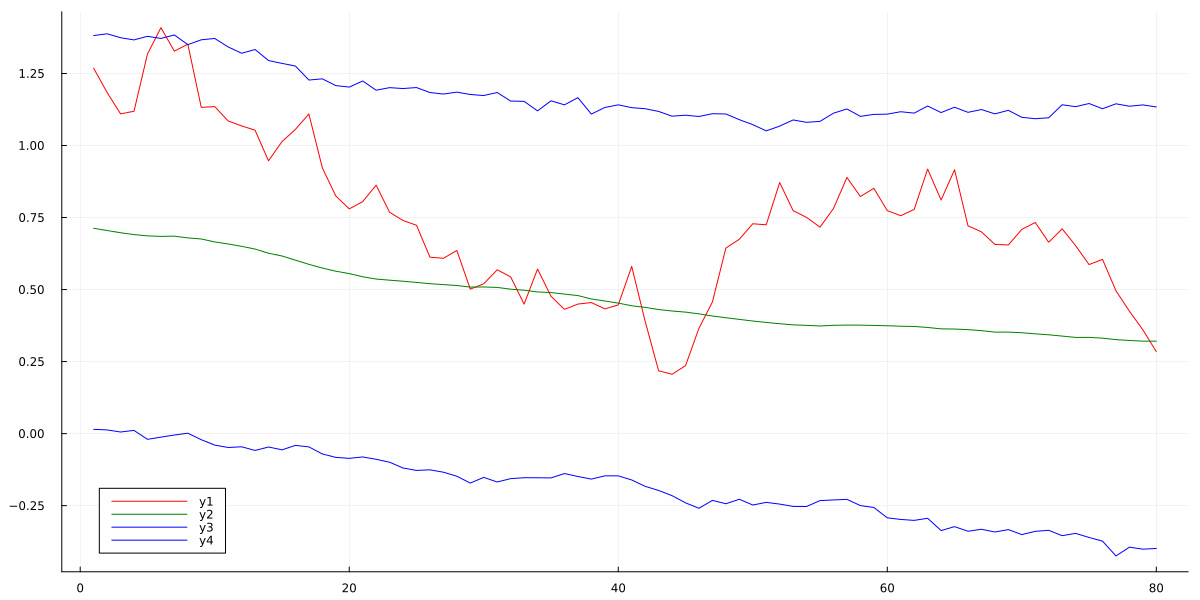

In [27]:
st = 2
plot(true_states[:,st]; color="red", size= (1200, 600))
plot!(trend_states_mean[:,st], color="green" )
plot!(trend_states_lower[:,st], color="blue")
plot!(trend_states_upper[:,st], color="blue")

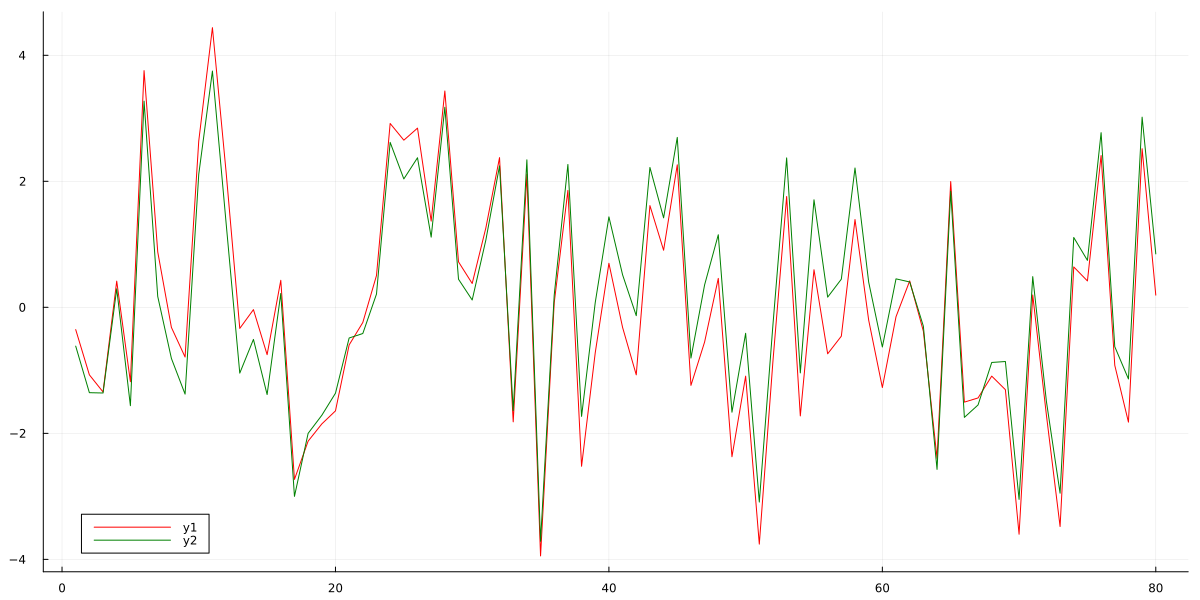

In [28]:
st=1
plot(true_states[:,3]; color="red", size= (1200, 600))
plot!(cycle_states_mean[:,st], color="green" )


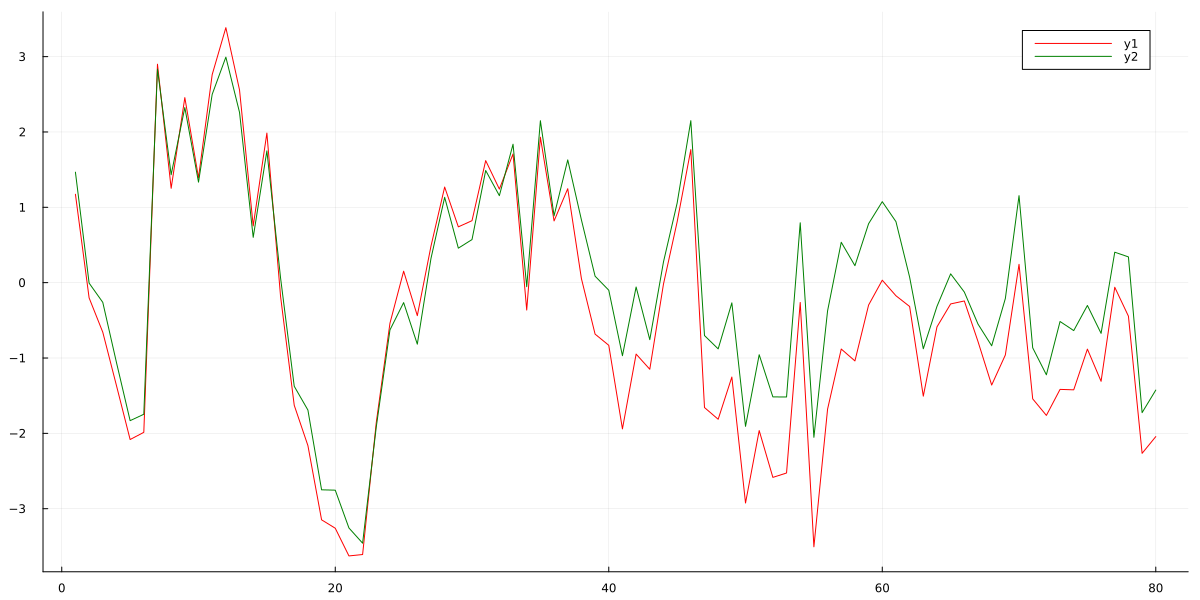

In [29]:
st = 2
plot(true_states[:,4]; color="red", size= (1200, 600))
plot!(cycle_states_mean[:,st], color="green" )

#plot!(state_smoothed_lower[:,st], color="blue")
#plot!(state_smoothed_upper[:,st], color="blue")

In [30]:
Y = true_states[:,[1,2]]
e  = diff(Y, dims=1)
true_var = e' * e * 1/(size(Y,1)-1)
display(diag(true_var))
display(diag(true_var).^.5)

2-element Vector{Float64}:
 0.039617432755271416
 0.007670898683064539

2-element Vector{Float64}:
 0.19904128404748453
 0.08758366675964496

In [31]:
summarystats(trend_covariance_samples)

Summary Statistics
  parameters      mean       std      mcse   ess_bulk    ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64    Float64     Float64   Float64    ⋯

       Στ[1]    0.0429    0.0064    0.0002   700.3815   1012.1658    1.0030    ⋯
       Στ[2]   -0.0000    0.0012    0.0000   978.1779    942.0177    1.0031    ⋯
       Στ[3]   -0.0000    0.0012    0.0000   978.1779    942.0177    1.0031    ⋯
       Στ[4]    0.0027    0.0004    0.0000   859.3908    909.9426    0.9996    ⋯
                                                                1 column omitted


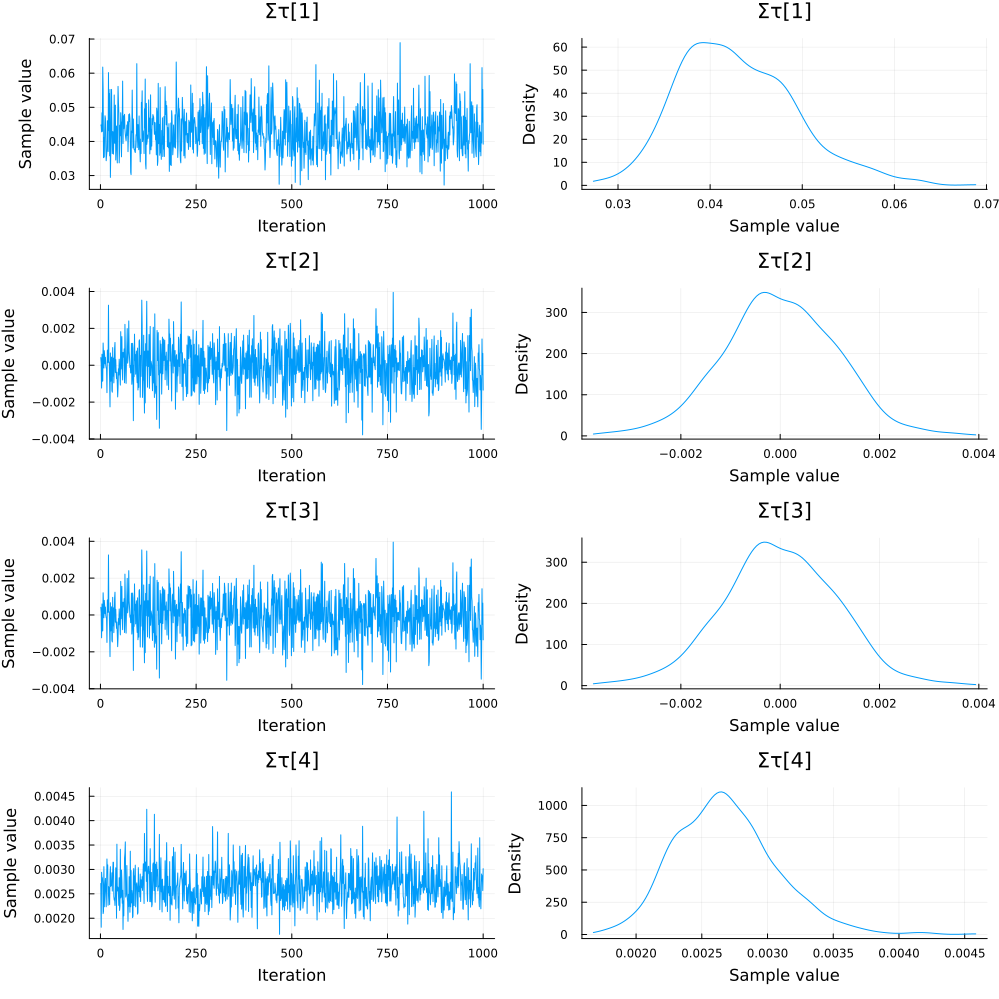

In [32]:
plot(trend_covariance_samples)

In [33]:
display(true_var_coeff)
summarystats(betas_samples)

2×2 Matrix{Float64}:
 0.3  0.1
 0.4  0.6

Summary Statistics
  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

          β1    0.0900    0.1079    0.0036    884.1042   679.5405    1.0006    ⋯
          β2    0.1533    0.1371    0.0042   1054.1907   912.4941    0.9993    ⋯
          β3    0.2357    0.0660    0.0021    996.8476   849.8336    0.9995    ⋯
          β4    0.4947    0.0949    0.0031    962.4744   974.5193    0.9994    ⋯
                                                                1 column omitted


In [34]:
display(true_cycle_covariance)
summarystats(sigmas_samples)

2×2 Matrix{Float64}:
  4.0      -0.00021
 -0.00021   1.0

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

       Σc[1]    3.4103    0.5730    0.0184    952.6554    884.7634    0.9998   ⋯
       Σc[2]   -0.0792    0.2652    0.0091    872.9580   1044.4571    0.9992   ⋯
       Σc[3]   -0.0792    0.2652    0.0091    872.9580   1044.4571    0.9992   ⋯
       Σc[4]    1.3969    0.2243    0.0071   1001.4396    901.9250    1.0013   ⋯
                                                                1 column omitted


uncoditional variance

In [35]:
unc_var  = (I(2) - true_var_coeff) * true_cycle_covariance
diag(unc_var) .^ .5

2-element Vector{Float64}:
 1.6733263280065844
 0.6325219363784943

In [36]:
Z = [1 0 0 0 1 0 0 0
       0 1 0 0 0 1 0 0
       0 1 1 0 0 0 1 0
       0 1 1 1 0 0 0 1]




4×8 Matrix{Int64}:
 1  0  0  0  1  0  0  0
 0  1  0  0  0  1  0  0
 0  1  1  0  0  0  1  0
 0  1  1  1  0  0  0  1

In [37]:
observation_tend_mapping  = [1 0 0 0 
                             0 1 0 0 
                             0 1 1 0 
                             0 1 1 1 ]

cycle_observation = I(4)

hcat(observation_tend_mapping, cycle_observation)

4×8 Matrix{Int64}:
 1  0  0  0  1  0  0  0
 0  1  0  0  0  1  0  0
 0  1  1  0  0  0  1  0
 0  1  1  1  0  0  0  1

In [38]:
gibs_sampler(data, trend_mapping, priors; burnin = 5_000, n_samples = 5_000, thin=5)

([3.8968430205710396 3.9117902658093655 … 2.1174353786217526 2.3131861191999503; 3.8725993623047277 3.8526364481111366 … 2.7131275606351415 2.697810011891354; … ; 3.621150391209932 3.646490091524198 … 3.4514569058112747 3.378589761080535; 3.5217823404193958 3.53580605279054 … 2.9804768611359305 3.180574171290529;;; 0.01601628976959589 -0.036115714489223114 … -0.1555525865479989 -0.22983991378687352; 1.155242747028454 1.1523031795640397 … 0.7379478887110658 0.7262012876703856; … ; 0.5160580541493128 0.5146098925611763 … 0.031722595379623575 -0.010897286449369992; 0.023621037969513727 0.03529217727529187 … -0.08571419733479672 -0.11423428403860558], [-1.0472696521475946 -1.7718566006510987 … 3.665925852649873 1.2746731054564409; -1.0225607869341862 -1.710703342201061 … 3.0678706234047475 0.8900466823465766; … ; -0.768176307380342 -1.5080176568606882 … 2.330589083480187 0.20927107422331293; -0.6719878050947092 -1.3967511731608862 … 2.8029968269132093 0.4072841055660847;;; 1.73112430100936